In [1]:
# INSGA3
import numpy as np
np.random.seed(0)
import geatpy as ea
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from hyperopt import hp,STATUS_OK,Trials,fmin,anneal
import joblib
import time
import warnings
warnings.filterwarnings("ignore")

d:\anconda\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
"""============================变量设置============================"""
NIND = 20                                  # 种群个体数目
Lind1 = 81                                 # 染色体长度
Lind2 = 3
length1= 1350 
length2= 1650
data = ""
best_acc = 0
best = []

"""==========================读取数据的方法========================="""
def load_data(select):
    target_stock = pd.read_csv("./dataset/n_"+data+".csv")
    y_train= target_stock[1:length1]["trend"]
    y_test = target_stock[length1:length2-1]["trend"]
    y_valid = target_stock[length2:-1]["trend"]
    if len(select) != 0:
        target_stock = target_stock.iloc[:,select]
    x_train = target_stock[0:length1-1]
    x_test = target_stock[length1-1:length2-2]
    x_valid = target_stock[length2-1:-2]
    # 归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    x_valid = scaler.fit_transform(x_valid)
    return x_train,y_train,x_test,y_test,x_valid,y_valid

"""============================先验函数============================"""
def prop(x):
    global Lind1,NIND
    # 返回先验种群
    x_xgb = x.copy()
    x_chi2 = x.copy()
    x_train,y_train,__,__,__,__ = load_data([])
    xgb = XGBClassifier()
    xgb.fit(x_train,y_train)
    thresholds = np.sort(xgb.feature_importances_)
    selection = SelectFromModel(xgb, threshold=thresholds[int(Lind1*(1-0.8))], prefit=True)
    XG0 = selection.get_support(indices=True)
    XG1 = np.zeros(Lind1)
    WR0 = SelectKBest(chi2, k=int(Lind1*0.8)).fit(x_train, y_train).get_support(indices=True)
    WR1 = np.zeros(Lind1)          
    for k in range(len(XG0)):
        XG1[XG0[k]]=1
    for k in range(len(WR0)):
        WR1[WR0[k]]=1
    for i in range(NIND):
        if i<NIND*0.8:
            for l in range(len(XG1)):
                if XG1[l]==1 and x[i][l]==1:
                    x_xgb[i][l] = 1
                else:
                    x_xgb[i][l] = 0
                if WR1[l]==1 and x[i][l]==1:
                    x_chi2[i][l] = 1
                else:
                    x_chi2[i][l] = 0
        else:
            for l in range(len(XG1)):
                if XG1[l]==1 and x[i][l]==0:
                    x_xgb[i][l] = 1
                else:
                    x_xgb[i][l] = 0
                if WR1[l]==1 and x[i][l]==0:
                    x_chi2[i][l] = 1
                else:
                    x_chi2[i][l] = 0 
    arr1 = aim(x_xgb)
    arr1 = np.hstack((arr1,x_xgb))
    arr2 = aim(x_chi2)
    arr2 = np.hstack((arr2,x_chi2))
    arr = np.vstack((arr1,arr2))
    arr_new = pd.DataFrame(arr).sort_values(by=[1],ascending=[False])[:NIND]
    arr_fit = np.array(arr_new[[0,1]])
    arr_param = np.array(arr_new[[2,3,4]]) 
    arr_new = arr_new.drop(arr_new.columns[[0,1,2,3,4]],axis=1)
    print("==========prop compute end==========")    
    return [[np.array(arr_new).astype(int),arr_param],arr_fit] # 返回的是Chroms和ObjV

def aim(x):                         # 传入种群染色体矩阵解码后的基因表现型矩阵
    global Lind1,NIND
    fitness = []        # 记录适应度矩阵
    count = np.zeros(NIND)    
    for i in range(NIND):
        select = []                 # 获取选择到特征的对应下标
        for j in range(Lind1):
            if x[i][j]==1:
               select.append(j)
               count[i] += 1
        x_train,y_train,x_test,y_test,__,__ = load_data(select)
        def opt():
            def hyperopt_train_test(params):
                clf = XGBClassifier(**params)
                clf.fit(x_train,y_train)
                y_pre=clf.predict(x_test)
                return accuracy_score(y_test,y_pre)
            space_svm = {
                'max_depth': hp.choice('max_depth', range(1,20)), #选择离散的值
                'n_estimators': hp.choice('n_estimators', range(1,20)),
                'learning_rate':hp.uniform('learning_rate',0.01,0.5)
            }  
            def f(params):
                acc = hyperopt_train_test(params)
                return {'loss': -acc, 'status': STATUS_OK}
            trials = Trials()
            best = fmin(f, space_svm, algo=anneal.suggest, max_evals=50, trials=trials)
            return [count[i],-min(trials.losses()),best['max_depth'],best['n_estimators'],best['learning_rate']]
        fitness.append(opt())
    fitness = np.array(fitness)
    return fitness
"""============================目标函数============================"""    
class MyProblem(ea.Problem):
    
    def __init__(self,M=2):
        global best_select
        name = "MyProblem"
        Dim = Lind1+Lind2 # 初始化决策变量维数
        maxormins = [1,-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        varTypes = [1] * Lind1 + [1] * (Lind2-1) + [0] # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Lind1 + [0] * Lind2   # 设置决策变量下界
        ub = [1] * Lind1 + [100] * (Lind2-1)+ [0.3]  # 设置决策变量上界
        lbin = [1] * Lind1 + [0] * Lind2 # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        
    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        def f1():
            global NIND
            # 返回选择特征个数
            fitness_f1 = []
            for i in range(NIND):
                fitness_f1.append(np.sum(Vars[i][:Lind1]==1)/Lind1)
            return np.array(fitness_f1).reshape(-1,1)
        def f2():
            # 返回训练准确度
            global Lind1,NIND,length,best_acc
            fitness_f2 = np.zeros(NIND)        # 记录适应度矩阵    
            for i in range(NIND):
                select = []                 # 获取选择到特征的对应下标
                count = 0           
                for j in range(Lind1):
                    if Vars[i][j]==1:
                        select.append(j)
                        count+=1             
                if(len(select)==0):
                    fitness_f2[i]=0
                    continue
                x_train,y_train,x_test,y_test,x_valid,y_valid = load_data(select)
                # 模型训练
                svc_clf = XGBClassifier()
                svc_clf.fit(x_train,y_train)
                y_pre=svc_clf.predict(x_test)
                y_pre_v = svc_clf.predict(x_valid)
                
                print("TEST_ACC: %.3f"%(accuracy_score(y_test,y_pre)*100))
                print("VALID_ACC: %.3f"%(accuracy_score(y_valid,y_pre_v)*100))
                print("*"*30)

                # 设置一个变量，最好的验证准确度，保存最优模型
                if(accuracy_score(y_valid,y_pre_v)>best_acc):
                    best_acc = accuracy_score(y_valid,y_pre_v)
                    pd.DataFrame(select).to_csv('mo_'+data+'.csv')
                    joblib.dump(svc_clf,'mo_'+data+'.dat')
                fitness_f2[i]=accuracy_score(y_test,y_pre)

            best.append(best_acc)
            return np.array(fitness_f2).reshape(-1,1)
        pop.ObjV = np.hstack([f1(), f2()])  # 把求得的目标函数值赋值给种群pop的ObjV

def main():
    global best_acc,best
    best = []
    best_acc = 0
    """===============================实例化问题对象============================"""
    problem = MyProblem()  # 生成问题对象
    """==================================种群设置==============================="""
    Encodings = ['BG','RI']  # 编码方式
    Field1 = ea.crtfld(Encodings[0], problem.varTypes[:Lind1],problem.ranges[:,:Lind1], problem.borders[:,:Lind1])
    Field2 = ea.crtfld(Encodings[1], problem.varTypes[Lind1:],problem.ranges[:,Lind1:], problem.borders[:,Lind1:])
    Fields = [Field1,Field2]
    population = ea.PsyPopulation(Encodings, Fields, NIND)  # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

    """================================算法参数设置============================="""
    myAlgorithm = ea.moea_psy_NSGA3_templet(problem, population)  # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 200  # 最大进化代数
    myAlgorithm.logTras = 1  # 设置每多少代记录日志，若设置成0则表示不记录日志
    myAlgorithm.verbose = False  # 设置是否打印输出日志信息
    myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
    """==========================调用算法模板进行种群进化=========================
    调用run执行算法模板，得到帕累托最优解集NDSet以及最后一代种群。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    详见Population.py中关于种群类的定义。
    """
    start_time = time.time()
    # population.initChrom()
    # ProChrom,ObjV= prop(population.Chroms[0])
    # prophetPop = ea.PsyPopulation(Encodings, Fields, NIND,ProChrom,ObjV)  # 实例化种群对象
    [NDSet, population] = myAlgorithm.run()  # 执行算法模板，得到非支配种群以及最后一代种群
    end_time = time.time()
    pd.DataFrame(best).to_csv("mo_fitness_"+data+".csv")
    f = open ('./实验结果/Mo_Time.txt','a')
    print(data+" 用时：\t",end_time-start_time,file=f)
    f.close()
    # NDSet.save()  # 把非支配种群的信息保存到文件中
    """==================================输出结果=============================="""
    print('用时：%s 秒' % myAlgorithm.passTime)
    print('非支配个体数：%d 个' % NDSet.sizes) if NDSet.sizes != 0 else print('没有找到可行解！')

HangSeng
TEST_ACC: 64.214
VALID_ACC: 75.238
******************************
TEST_ACC: 70.903
VALID_ACC: 79.524
******************************
TEST_ACC: 78.261
VALID_ACC: 78.571
******************************
TEST_ACC: 65.217
VALID_ACC: 72.381
******************************
TEST_ACC: 63.545
VALID_ACC: 60.000
******************************
TEST_ACC: 79.264
VALID_ACC: 68.095
******************************
TEST_ACC: 69.565
VALID_ACC: 70.000
******************************
TEST_ACC: 73.913
VALID_ACC: 77.619
******************************
TEST_ACC: 78.930
VALID_ACC: 75.714
******************************
TEST_ACC: 77.258
VALID_ACC: 79.524
******************************
TEST_ACC: 69.900
VALID_ACC: 73.333
******************************
TEST_ACC: 69.900
VALID_ACC: 79.048
******************************
TEST_ACC: 75.585
VALID_ACC: 76.667
******************************
TEST_ACC: 78.261
VALID_ACC: 75.714
******************************
TEST_ACC: 63.211
VALID_ACC: 74.762
******************************
T

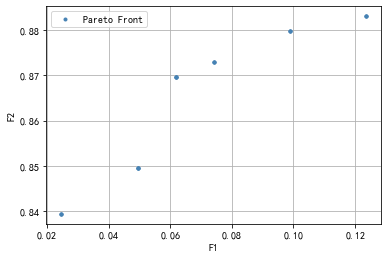

用时：437.61087942123413 秒
非支配个体数：20 个
CSI300
TEST_ACC: 71.237
VALID_ACC: 75.824
******************************
TEST_ACC: 72.241
VALID_ACC: 82.967
******************************
TEST_ACC: 67.559
VALID_ACC: 75.275
******************************
TEST_ACC: 67.893
VALID_ACC: 73.077
******************************
TEST_ACC: 65.217
VALID_ACC: 75.275
******************************
TEST_ACC: 69.900
VALID_ACC: 79.121
******************************
TEST_ACC: 75.920
VALID_ACC: 76.923
******************************
TEST_ACC: 67.893
VALID_ACC: 83.516
******************************
TEST_ACC: 74.916
VALID_ACC: 82.418
******************************
TEST_ACC: 72.910
VALID_ACC: 82.967
******************************
TEST_ACC: 62.207
VALID_ACC: 73.626
******************************
TEST_ACC: 70.569
VALID_ACC: 75.275
******************************
TEST_ACC: 64.214
VALID_ACC: 64.835
******************************
TEST_ACC: 75.920
VALID_ACC: 82.418
******************************
TEST_ACC: 63.545
VALID_ACC: 71.42

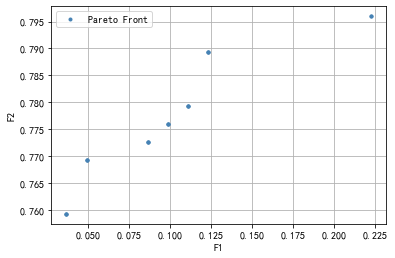

用时：462.09843945503235 秒
非支配个体数：20 个
DJIA
TEST_ACC: 71.237
VALID_ACC: 70.356
******************************
TEST_ACC: 72.910
VALID_ACC: 75.494
******************************
TEST_ACC: 72.910
VALID_ACC: 75.494
******************************
TEST_ACC: 77.592
VALID_ACC: 71.937
******************************
TEST_ACC: 73.579
VALID_ACC: 75.889
******************************
TEST_ACC: 74.916
VALID_ACC: 75.889
******************************
TEST_ACC: 74.247
VALID_ACC: 81.028
******************************
TEST_ACC: 70.903
VALID_ACC: 74.308
******************************
TEST_ACC: 64.548
VALID_ACC: 66.008
******************************
TEST_ACC: 79.264
VALID_ACC: 75.889
******************************
TEST_ACC: 65.886
VALID_ACC: 69.960
******************************
TEST_ACC: 79.933
VALID_ACC: 74.704
******************************
TEST_ACC: 73.244
VALID_ACC: 77.075
******************************
TEST_ACC: 75.585
VALID_ACC: 73.913
******************************
TEST_ACC: 76.254
VALID_ACC: 75.494


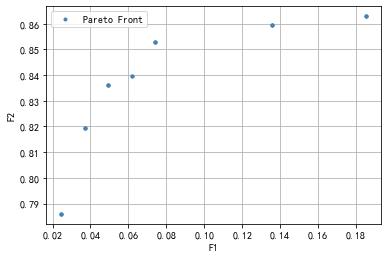

用时：400.36146545410156 秒
非支配个体数：20 个


In [3]:
stock_list = ["HangSeng","CSI300","DJIA"]
for item in stock_list:
    print(item)
    data = item
    main()